<a href="https://colab.research.google.com/github/ErdemKilci/ReservoirWind/blob/main/reservoir_wind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Power Consumption Forecasting Project

## Project Goal:
This project aims to analyze and model power consumption based on actual and forecasted loads using machine learning.

## Data Source:
- **Time**
- **Forecast Load**
- **Actual Load**

## Steps Taken So Far:
1. **Data Loading**
2. **Data Cleaning**
3. **Missing Values Analysis**
4. **Basic Data Visualization**
5. **Time-Series Plots**
6. **Error Analysis**

In [25]:
pip install pandas matplotlib openpyxl plotly ipywidgets seaborn scipy statsmodels scikit-learn

Note: you may need to restart the kernel to use updated packages.


## Data Loading and Cleaning
### Goal:
- Read all Excel files
- Merge them into one dataset
- Remove unnecessary rows
- Rename columns
- Convert data types

### Code:

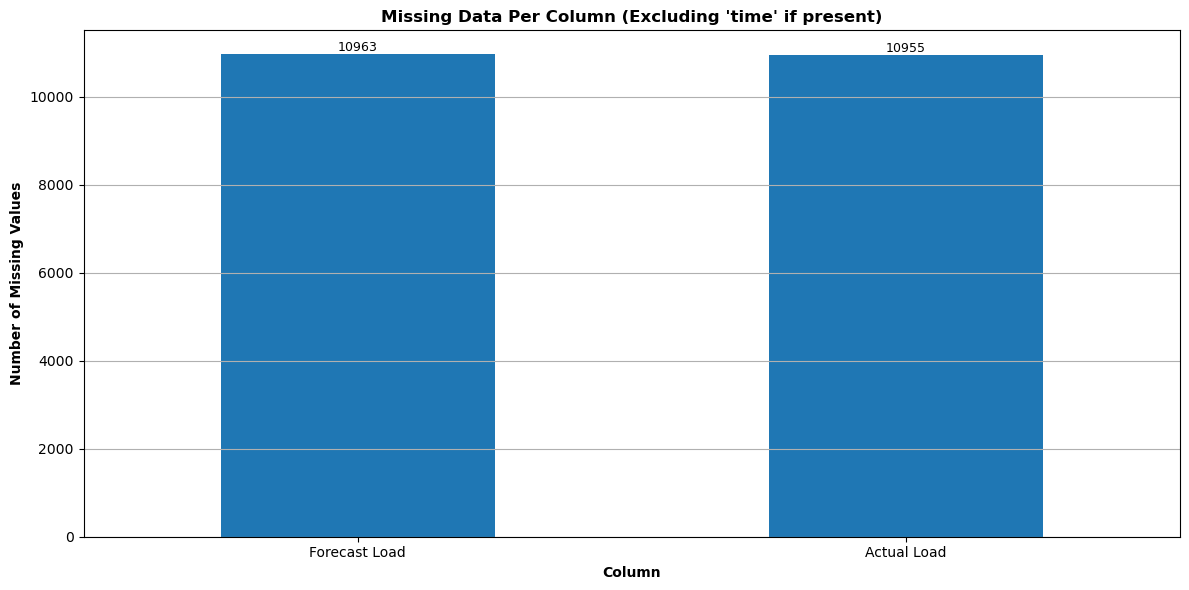

Missing Values Count (Raw Data):
 Time              7296
Forecast Load    10963
Actual Load      10955
dtype: int64

Missing Values Percentage (Raw Data):
 Time              7.398019
Forecast Load    11.116294
Actual Load      11.108182
dtype: float64
Time range in data: 2015-01-01 00:00:00 to 2024-12-31 23:00:00


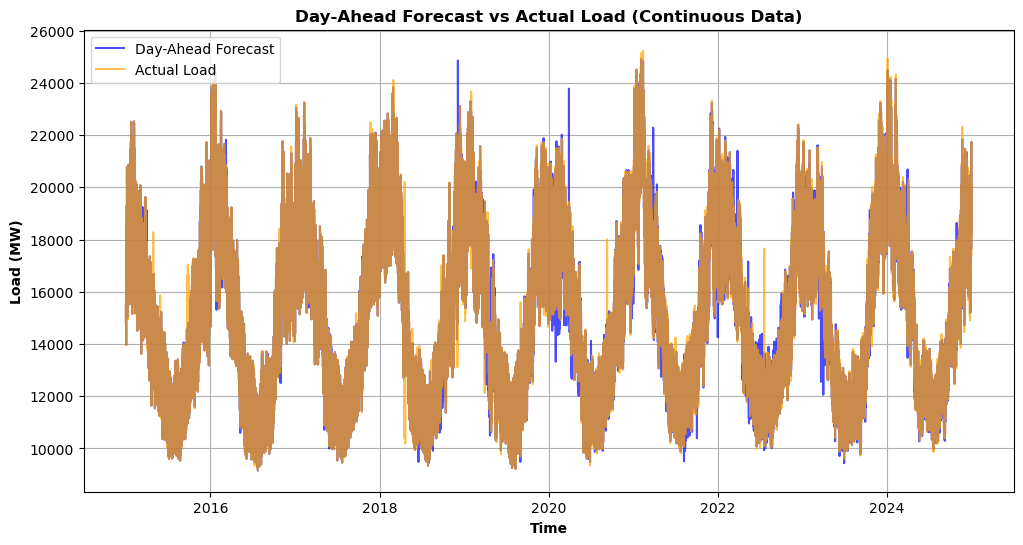

'\nimport pandas as pd\nimport os\nimport matplotlib.pyplot as plt\n\n# Example for file path\ndata_folder = "Data"\nexcel_files = sorted([f for f in os.listdir(data_folder) if f.endswith(\'.xlsx\')])  # Sort files chronologically\n\nall_data = pd.DataFrame()\n\n# Manually define the initial start date\ncurrent_datetime = pd.Timestamp("2014-01-01 00:00:00")  # Adjust based on the first file\n\nfor file in excel_files:\n    file_path = os.path.join(data_folder, file)\n    # Read Excel file\n    data = pd.read_excel(file_path, skiprows=7)  # Skip metadata rows\n\n    # Rename columns\n    data.columns = [\'Time\', \'Forecast Load\', \'Actual Load\']\n\n    # Use a counter to process 24 rows and skip the next 3 rows, with reset logic\n    filtered_data = pd.DataFrame()\n    count = 0  # Counter for rows\n    skip = 1  # Tracks rows to be skipped\n\n    for index, row in data.iterrows():\n        # If we are in the skipping phase, decrement the skip counter and continue\n        if skip > 

In [26]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns

# Define file paths
data_folder = "Data"
excel_files = sorted([f for f in os.listdir(data_folder) if f.endswith('.xlsx')])  # Sort files chronologically

raw_data_list = [] # To store raw data for vis..
all_data = pd.DataFrame() # This will store the cleaned data.

for file in excel_files:
    file_path = os.path.join(data_folder, file)

    # Extract year from filename (filename is just "2014.xlsx", "2015.xlsx", etc.)
    file_year = os.path.splitext(file)[0]  # Removes .xlsx and takes only the year

    # Read Excel file, skipping 6 rows
    data = pd.read_excel(file_path, skiprows=6, dtype=str)

        #Cleaning process
    # Rename first row as actual column names
    data.columns = ['Time', 'Forecast Load', 'Actual Load']

    # Store a copy of the raw data after column rename (before further cleaning)
    raw_data_list.append(data.copy())


    #Cleaning process
    # Rename first row as actual column names
    data.columns = ['Time', 'Forecast Load', 'Actual Load']
    
    # Rename second row with year-specific timestamp
    data.iloc[0] = [f'01.01.{file_year}', '', '']

    # Drop fully empty rows
    data = data.dropna(how='all')

    # Identify rows with date markers (xx.xx.xxxx format)
    date_mask = data['Time'].str.match(r'\d{2}\.\d{2}\.\d{4}', na=False)
    data['Is_Date'] = date_mask
    
    # Fill forward the date values
    data['Date'] = data.loc[data['Is_Date'], 'Time']
    data['Date'] = data['Date'].ffill()
    
    # Remove the rows that contain only the date markers
    data = data[~data['Is_Date']]
    
    # Convert "Time" format from "HH:MM - HH:MM" to just "HH:MM"
    data['Time'] = data['Time'].str.split(' - ').str[0]
    
    # Combine Date and Time to create full timestamp
    data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d.%m.%Y %H:%M', errors='coerce')
    
    # Convert Forecast and Actual Load to numeric, handling errors
    data['Forecast Load'] = pd.to_numeric(data['Forecast Load'], errors='coerce')
    data['Actual Load'] = pd.to_numeric(data['Actual Load'], errors='coerce')

    # Append cleaned data
    all_data = pd.concat([all_data, data[['Timestamp', 'Forecast Load', 'Actual Load']]], ignore_index=True)

# Combine all raw data for visualization
raw_data = pd.concat(raw_data_list, ignore_index=True)

# Exclude any columns that start with 'Unnamed'
# Strip any whitespace around column names
raw_data.columns = raw_data.columns.str.strip()
# Drop columns containing 'Unnamed' in the name
raw_data = raw_data.loc[:, ~raw_data.columns.str.contains('^Unnamed', case=False)]

# Visualize missing values in raw data (before cleaning), row by row
# Prepare raw data for visualization (before cleaning)

# Reset index for clarity
raw_data_reset = raw_data.reset_index(drop=True)

# Select only relevant columns
raw_data_vis = raw_data_reset[['Forecast Load', 'Actual Load']].copy()

# Convert to NaN where applicable (just in case some empty strings remain)
raw_data_vis.replace('', np.nan, inplace=True)

# Drop 'time' column only if it exists
columns = raw_data_vis.columns.drop('time', errors='ignore')

# Calculate number of missing values per column (excluding 'time' if present)
missing_per_column = raw_data_vis[columns].isnull().sum()

# Plot
plt.figure(figsize=(12, 6))
ax = missing_per_column.plot(kind='bar', stacked=False)
plt.title("Missing Data Per Column (Excluding 'time' if present)", fontweight = 'bold')
plt.ylabel("Number of Missing Values", fontweight = 'bold')
plt.xlabel("Column", fontweight = 'bold')
plt.grid(axis='y')
plt.xticks(rotation=360)
plt.tight_layout()

# Add exact numbers on top of each bar
for i, value in enumerate(missing_per_column):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)
plt.savefig("raw_empty_row.pdf", dpi=300, format="pdf")
plt.show()



#Print missing values counts and percentages for raw data
missing_counts = raw_data.isnull().sum()
missing_percent = raw_data.isnull().mean()*100
print("Missing Values Count (Raw Data):\n", missing_counts)
print("\nMissing Values Percentage (Raw Data):\n", missing_percent)

# After: Visualise Cleaned Data

# Verify the range of the data
print("Time range in data:", all_data['Timestamp'].min(), "to", all_data['Timestamp'].max())

# Plot the data, ensuring no missing hours
plt.figure(figsize=(12, 6))
plt.plot(all_data['Timestamp'], all_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
plt.plot(all_data['Timestamp'], all_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
plt.xlabel('Time', fontweight = 'bold')
plt.ylabel('Load (MW)', fontweight = 'bold')
plt.title('Day-Ahead Forecast vs Actual Load (Continuous Data)', fontweight = 'bold')
plt.savefig("time_series.pdf", dpi=300, format="pdf")
plt.legend()
plt.grid()
plt.show()

'''
# --- **INSERT CODE FOR HANDLING MISSING LAST TWO MONTHS HERE** ---
last_year_data = all_data['Timestamp'].dt.year.max() # Identify the last year in your data
missing_months = [10, 11, 12] # November and December

# 1. Identify timestamps for the missing last two months of the last year
start_missing_date = pd.to_datetime(f'2024-10-31 11:00:00')
end_missing_date = pd.to_datetime(f'{last_year_data}-12-31 23:00:00')
missing_timestamps = pd.date_range(start=start_missing_date, end=end_missing_date, freq='H') # Hourly timestamps

# 2. Filter historical data (excluding the last year) and for Nov/Dec
historical_data = all_data[all_data['Timestamp'].dt.year < 2024]
historical_nov_dec = historical_data[historical_data['Timestamp'].dt.month.isin(missing_months)]

# 3. Calculate average hourly load for Nov/Dec across historical years
average_hourly_load = historical_nov_dec.groupby(historical_nov_dec['Timestamp'].dt.hour).agg(
    {'Forecast Load': 'mean', 'Actual Load': 'mean'}
).rename(columns={'Forecast Load': 'Avg Forecast Load', 'Actual Load': 'Avg Actual Load'})

# 4. Create a DataFrame for the missing months with imputed values
imputed_data_list = []
for ts in missing_timestamps:
    hour = ts.hour
    if hour in average_hourly_load.index: # Make sure hour exists in average data (should always be true for hourly data)
        imputed_data_list.append({
            'Timestamp': ts,
            'Forecast Load': average_hourly_load.loc[hour, 'Avg Forecast Load'],
            'Actual Load': average_hourly_load.loc[hour, 'Avg Actual Load']
        })

imputed_data_df = pd.DataFrame(imputed_data_list)

# 5. Concatenate imputed data with the original all_data
all_data = pd.concat([all_data, imputed_data_df], ignore_index=True)

# Sort by timestamp to maintain chronological order
all_data = all_data.sort_values(by='Timestamp').reset_index(drop=True)

# Verify the range of the data *after* imputation
print("Time range in data after imputation:", all_data['Timestamp'].min(), "to", all_data['Timestamp'].max())


# Plot the data, ensuring no missing hours
plt.figure(figsize=(12, 6))
plt.plot(all_data['Timestamp'], all_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
plt.plot(all_data['Timestamp'], all_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.title('Day-Ahead Forecast vs Actual Load (Continuous Data)')
plt.legend()
plt.grid()
plt.show()
'
'''


# Old Code
"""
import pandas as pd
import os
import matplotlib.pyplot as plt

# Example for file path
data_folder = "Data"
excel_files = sorted([f for f in os.listdir(data_folder) if f.endswith('.xlsx')])  # Sort files chronologically

all_data = pd.DataFrame()

# Manually define the initial start date
current_datetime = pd.Timestamp("2014-01-01 00:00:00")  # Adjust based on the first file

for file in excel_files:
    file_path = os.path.join(data_folder, file)
    # Read Excel file
    data = pd.read_excel(file_path, skiprows=7)  # Skip metadata rows

    # Rename columns
    data.columns = ['Time', 'Forecast Load', 'Actual Load']

    # Use a counter to process 24 rows and skip the next 3 rows, with reset logic
    filtered_data = pd.DataFrame()
    count = 0  # Counter for rows
    skip = 1  # Tracks rows to be skipped

    for index, row in data.iterrows():
        # If we are in the skipping phase, decrement the skip counter and continue
        if skip > 0:
            skip -= 1
            continue

        # Include the current row in the filtered_data
        filtered_data = pd.concat([filtered_data, pd.DataFrame([row])])
        count += 1

        # Once 24 rows are processed, skip the next 3 rows and reset the counter
        if count == 24:
            skip = 3  # Set skip counter for the next 3 rows
            count = 0  # Reset the counter

    # Generate timestamps dynamically based on the current_datetime
    num_rows = len(filtered_data)
    time_range = pd.date_range(start=current_datetime, periods=num_rows, freq='h')
    filtered_data['Time'] = time_range

    # Update current_datetime to continue from the end of this file's data
    current_datetime = time_range[-1] + pd.Timedelta(hours=1)

    # Convert columns to numeric, preserving NaN values
    filtered_data['Forecast Load'] = pd.to_numeric(filtered_data['Forecast Load'], errors='coerce')
    filtered_data['Actual Load'] = pd.to_numeric(filtered_data['Actual Load'], errors='coerce')

    # Append to the combined DataFrame
    all_data = pd.concat([all_data, filtered_data[['Time', 'Forecast Load', 'Actual Load']]], ignore_index=True)

# Verify the range of the data
print("Time range in data:", all_data['Time'].min(), "to", all_data['Time'].max())

# Plot the data, including null values
plt.figure(figsize=(12, 6))
plt.plot(all_data['Time'], all_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
plt.plot(all_data['Time'], all_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.title('Day-Ahead Forecast vs Actual Load (With Skipped Rows)')
plt.legend()
plt.grid()
plt.show()
"""


## Data Visualization

### Plots Created:
1. Forecast vs Actual Load (Time Series)
2. Yearly Trend Analysis
3. Forecast Error Over Time
4. Missing Data Heatmap


In [27]:
print(data.head())       # Check first few rows
print(data.describe())   # Statistical summary
print(data.isnull().sum())  # Missing values


    Time  Forecast Load  Actual Load  Is_Date        Date           Timestamp
1  00:00        17872.0      18350.0    False  01.01.2024 2024-01-01 00:00:00
2  01:00        18118.0      18364.0    False  01.01.2024 2024-01-01 01:00:00
3  02:00        17993.0      18224.0    False  01.01.2024 2024-01-01 02:00:00
4  03:00        17851.0      18030.0    False  01.01.2024 2024-01-01 03:00:00
5  04:00        17827.0      18009.0    False  01.01.2024 2024-01-01 04:00:00
       Forecast Load   Actual Load                      Timestamp
count    8784.000000   8784.000000                           8785
mean    15554.240779  15577.568420  2024-07-01 23:49:11.713147648
min      9965.000000   9862.000000            2024-01-01 00:00:00
25%     12759.750000  12841.750000            2024-04-01 12:00:00
50%     15250.000000  15228.500000            2024-07-02 00:00:00
75%     17989.500000  17962.000000            2024-10-01 12:00:00
max     24480.000000  24930.000000            2024-12-31 23:00:00
std 

### Analyse Data Each Year

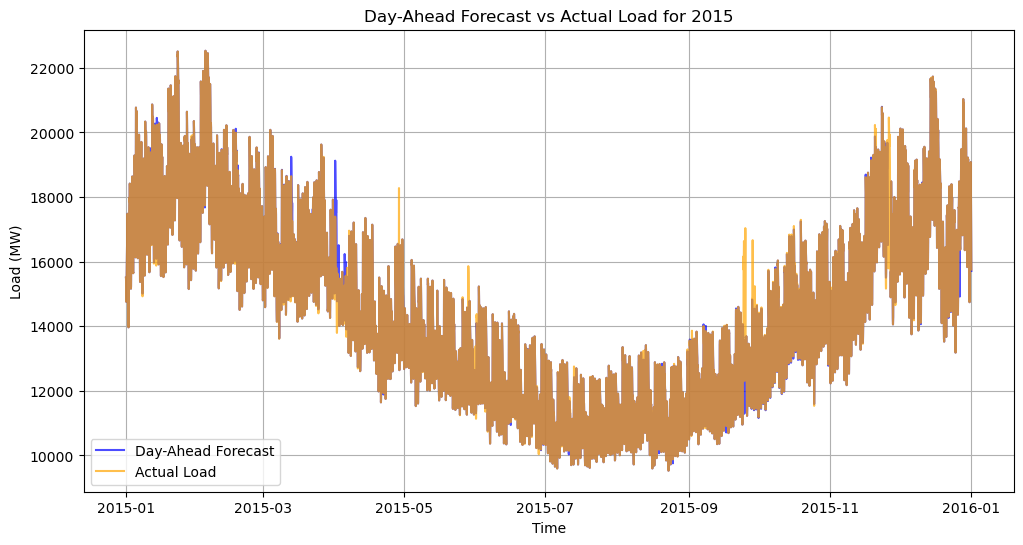

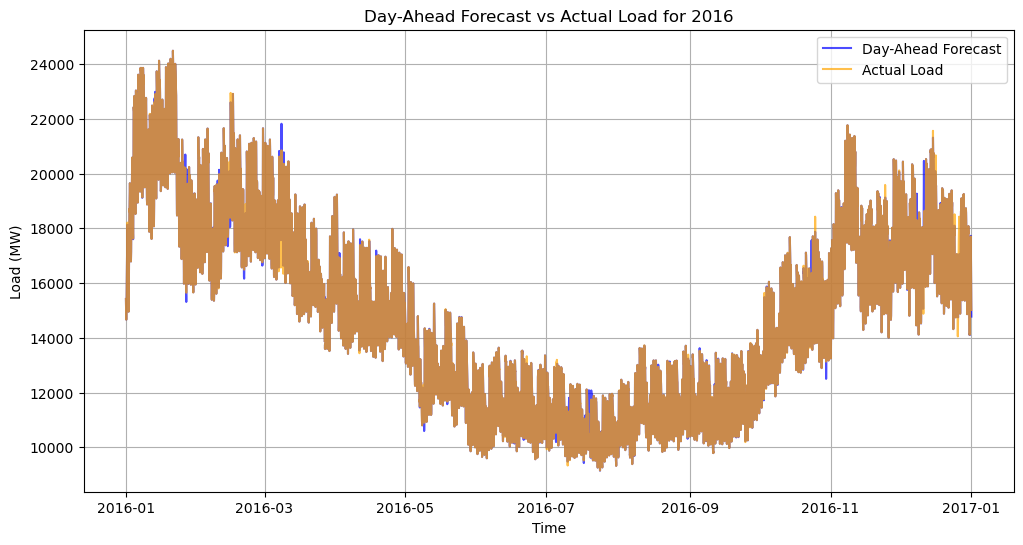

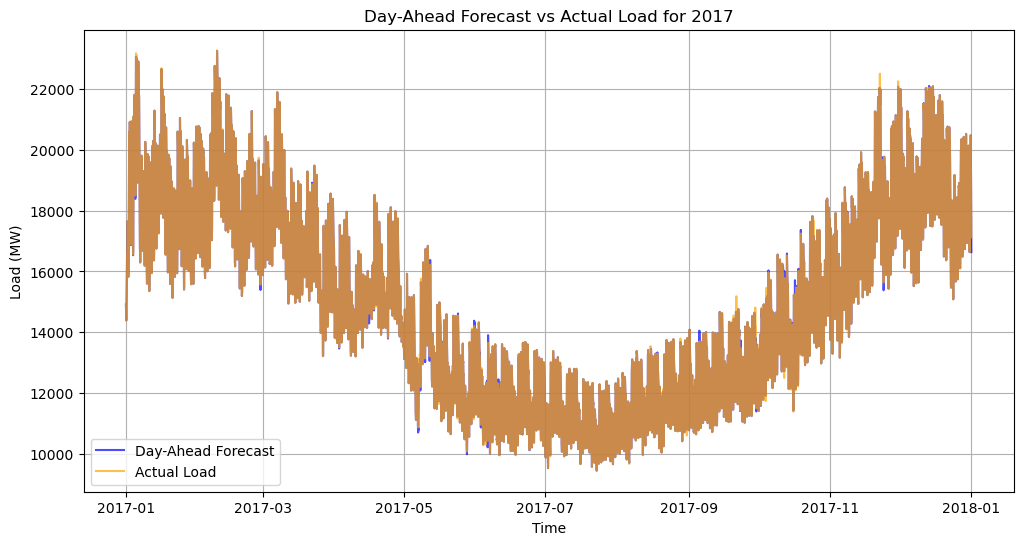

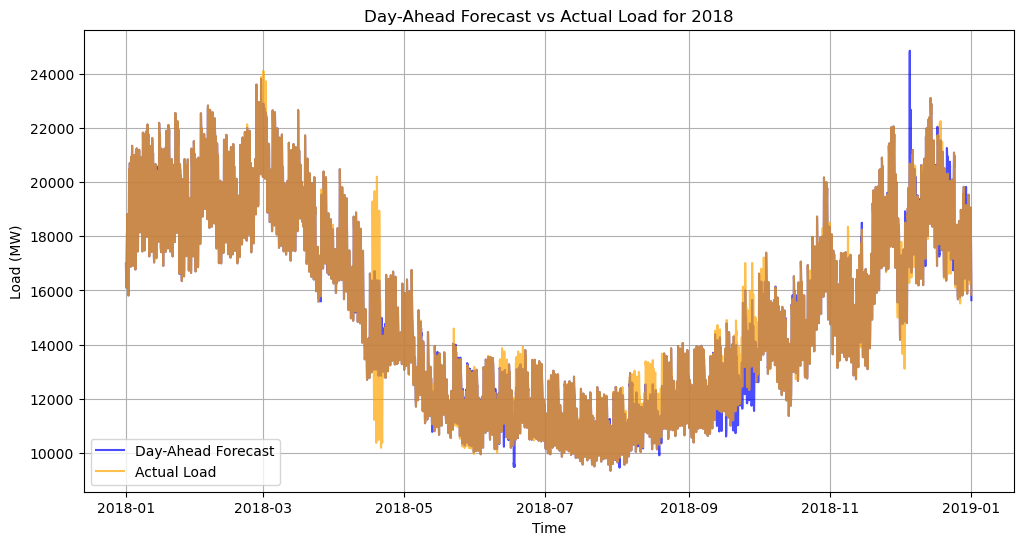

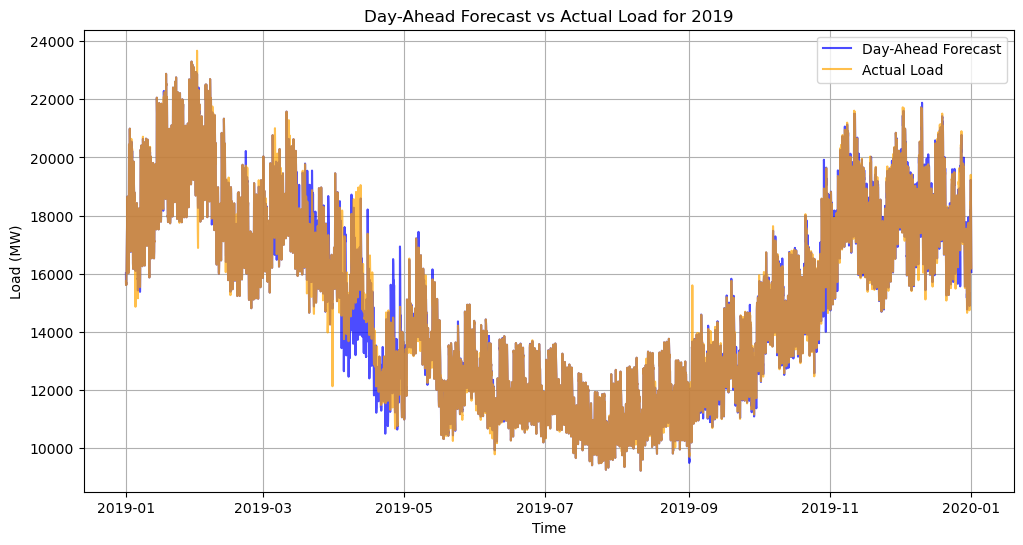

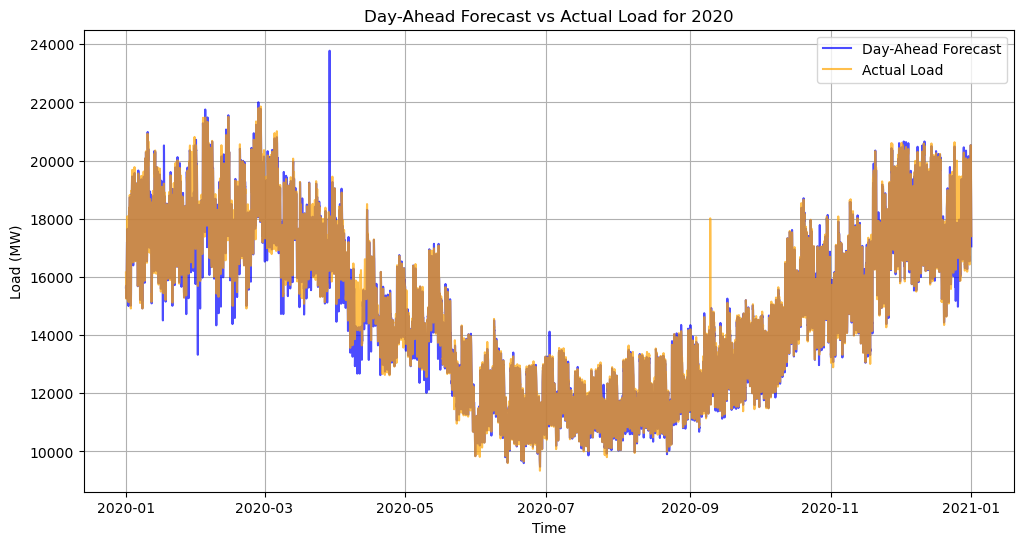

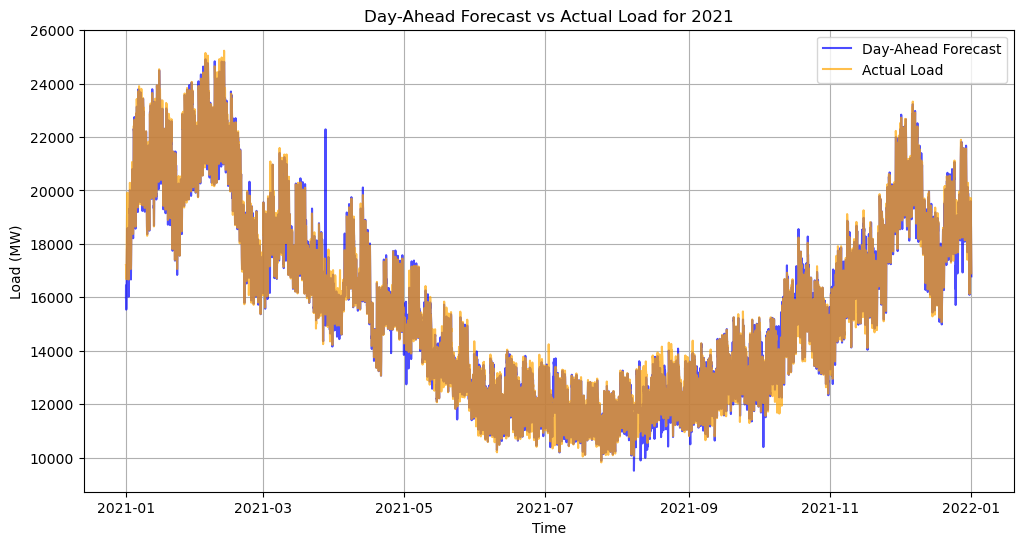

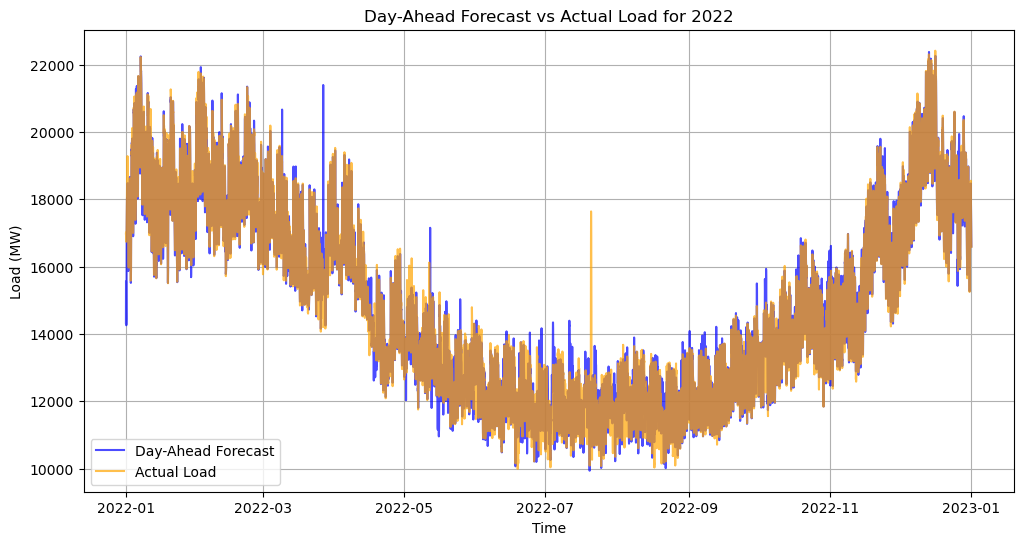

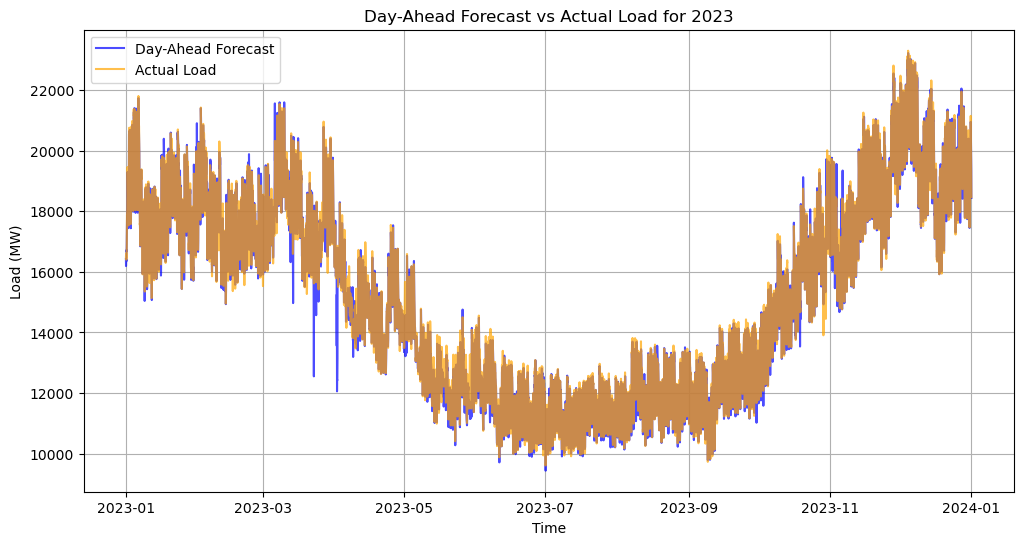

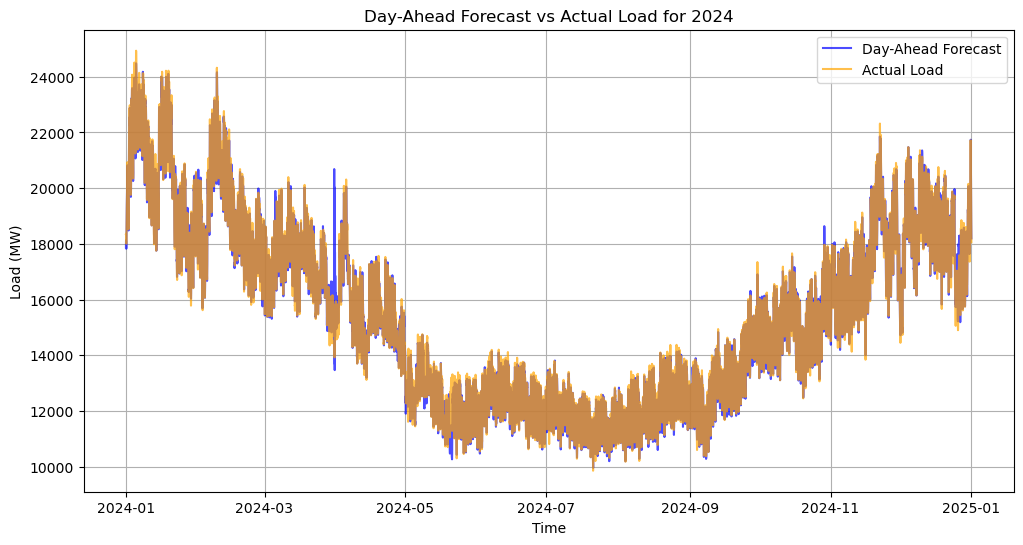

In [28]:
# Group data by year
for year, year_data in all_data.groupby(all_data['Timestamp'].dt.year):
    plt.figure(figsize=(12, 6))
    plt.plot(year_data['Timestamp'], year_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
    plt.plot(year_data['Timestamp'], year_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
    plt.xlabel('Time')
    plt.ylabel('Load (MW)')
    plt.title(f'Day-Ahead Forecast vs Actual Load for {year}')
    plt.legend()
    plt.grid()
    plt.show()


## Exploratory Data Analysis (EDA)

### What we analyzed:
- Summary statistics
- Missing values
- Time range verification

### Summary Statistics

In [29]:
# Ensure 'Timestamp' is in datetime format
all_data['Year'] = all_data['Timestamp'].dt.year  # Extract the year

# Group by year and calculate statistics
summary_stats = all_data.groupby('Year').agg({
    'Forecast Load': ['mean', 'max', 'min'],
    'Actual Load': ['mean', 'max', 'min']
})

# Print summary statistics
print(summary_stats)




     Forecast Load                    Actual Load                 
              mean      max     min          mean      max     min
Year                                                              
2015  14679.735119  22531.0  9527.0  14689.310388  22530.0  9527.0
2016  15073.934882  24485.0  9147.0  15070.784101  24485.0  9157.0
2017  15170.839155  23246.0  9458.0  15169.687215  23246.0  9457.0
2018  15400.935388  24854.0  9342.0  15467.212557  24108.0  9343.0
2019  15224.333447  23300.0  9217.0  15236.381963  23672.0  9217.0
2020  15100.248634  23779.0  9476.0  15125.462090  21861.0  9338.0
2021  15831.555708  24911.0  9508.0  15857.231735  25230.0  9820.0
2022  15015.697146  22379.0  9938.0  15023.900457  22416.0  9992.0
2023  15312.009932  23229.0  9435.0  15352.816210  23305.0  9608.0
2024  15554.240779  24480.0  9965.0  15577.568420  24930.0  9862.0


### Comment Summary stats
burasini inceledigmizde goruyoruz ki 2014 yilinin gunde en az harcandigi enerji miktarri 14295.0
lakin diger yillara baktigimizda 2015 ve sonrasi icin geneli 9500 kusurde. Bunun nedeni 2014 yilinin sadece aralik ayinin degerlendirilmesi diger verilerin olmamasi yani yaz ve kis kiyaslamasi yok.



### Saving Processed Data

In [30]:
all_data.to_csv('combined_data.csv', index=False)


### Missing Data HeatMap

<Figure size 1200x600 with 0 Axes>

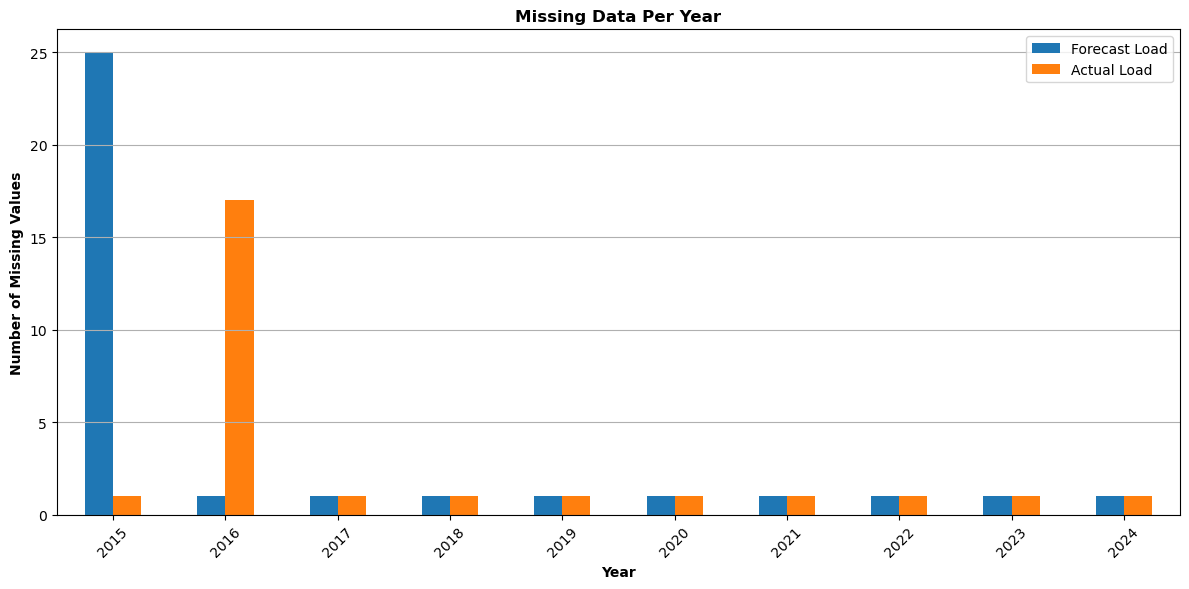

=== Missing Values by Year ===
       Timestamp  Forecast Load  Actual Load  Year
2015           0             25            1     0
2016           0              1           17     0
2017           0              1            1     0
2018           0              1            1     0
2019           0              1            1     0
2020           0              1            1     0
2021           0              1            1     0
2022           0              1            1     0
2023           0              1            1     0
2024           0              1            1     0
Total          0             34           26     0

=== Detailed Missing Values with Timestamps ===
        Year           Timestamp         Column
2090    2015 2015-03-29 02:00:00  Forecast Load
7897    2015 2015-11-26 00:00:00  Forecast Load
7898    2015 2015-11-26 01:00:00  Forecast Load
7899    2015 2015-11-26 02:00:00  Forecast Load
7900    2015 2015-11-26 03:00:00  Forecast Load
7901    2015 2015-11

In [31]:
import matplotlib.pyplot as plt

# Group by year and count missing values
missing_by_year = all_data.groupby(all_data['Timestamp'].dt.year)[['Forecast Load', 'Actual Load']].apply(lambda x: x.isnull().sum())

# Drop NaN years (if Timestamp was NaT)
missing_by_year = missing_by_year.dropna()

# Plot
plt.figure(figsize=(12, 6))
missing_by_year.plot(kind='bar', stacked=False, figsize=(12, 6))

plt.title("Missing Data Per Year", fontweight='bold')
plt.ylabel("Number of Missing Values", fontweight='bold')
plt.xlabel("Year", fontweight='bold')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("missing_value_chart.pdf", dpi=300, format="pdf")
plt.show()


# Step 1: Missing count per year
missing_by_year = all_data.groupby(all_data['Timestamp'].dt.year).apply(lambda x: x.isnull().sum())

# Step 2: Add total row
total_missing = all_data.isnull().sum()
total_missing.name = 'Total'
missing_by_year = pd.concat([missing_by_year, total_missing.to_frame().T])

# Step 3: Display missing counts
print("=== Missing Values by Year ===")
print(missing_by_year)

# Step 4: Show detailed list of each missing value
print("\n=== Detailed Missing Values with Timestamps ===")

# Melt the DataFrame to long format
melted = all_data[['Timestamp', 'Forecast Load', 'Actual Load']].melt(id_vars='Timestamp',
                                                                      var_name='Column',
                                                                      value_name='Value')
# Filter missing values
missing_details = melted[melted['Value'].isnull()].copy()

# Extract Year from Timestamp
missing_details['Year'] = missing_details['Timestamp'].dt.year

# Display or save
print(missing_details[['Year', 'Timestamp', 'Column']])


### Handle Missing Data & HeatMap

<Figure size 1200x600 with 0 Axes>

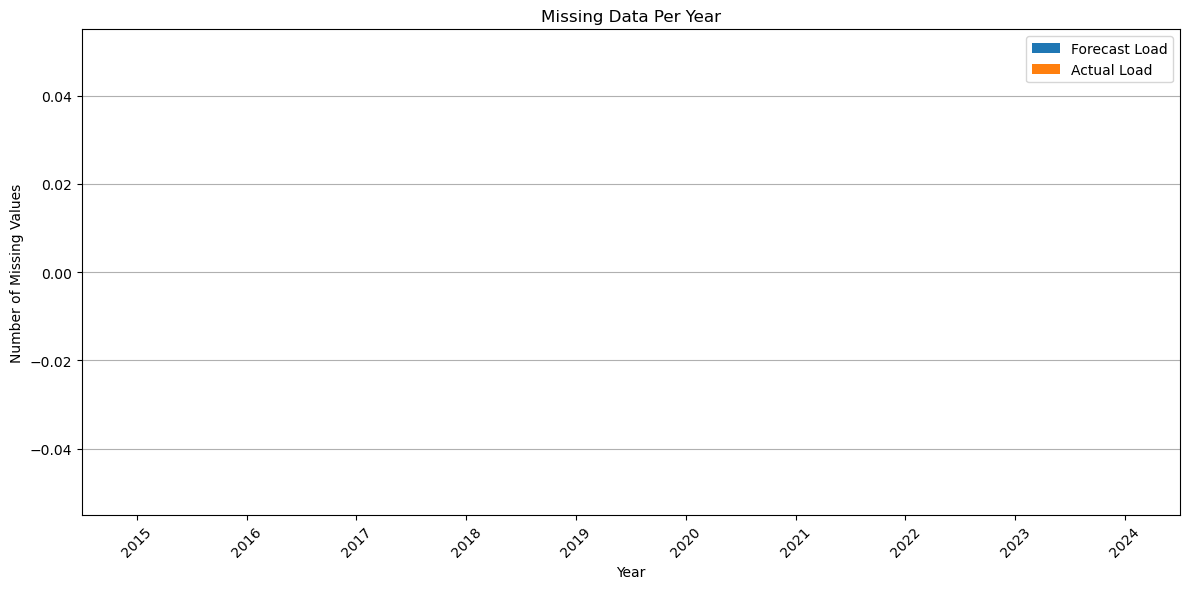

=== Missing Values by Year ===
       Forecast Load  Actual Load  Timestamp  Year
2015               0            0        NaN   NaN
2016               0            0        NaN   NaN
2017               0            0        NaN   NaN
2018               0            0        NaN   NaN
2019               0            0        NaN   NaN
2020               0            0        NaN   NaN
2021               0            0        NaN   NaN
2022               0            0        NaN   NaN
2023               0            0        NaN   NaN
2024               0            0        NaN   NaN
Total              0            0        0.0   0.0

=== Detailed Missing Values with Timestamps ===
Empty DataFrame
Columns: [Year, Timestamp, Column]
Index: []


In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def smart_fill_hourly_by_pattern(data, max_gap_hours=6):
    """
    Interpolates short gaps using cubic.
    Fills longer gaps hour-by-hour using average of same hour/weekday from previous weeks.
    """
    from datetime import timedelta

    df = data.copy()
    df = df.sort_values('Timestamp').reset_index(drop=True)

    # Add helper columns
    df['Weekday'] = df['Timestamp'].dt.weekday  # Monday=0
    df['Hour'] = df['Timestamp'].dt.hour

    # Step 1: Interpolate short gaps with cubic
    for col in ['Forecast Load', 'Actual Load']:
        df[col] = df[col].interpolate(method='cubic', limit_area='inside', limit_direction='both')

    # Step 2: Fill longer gaps hour-by-hour from past weekly patterns
    for col in ['Forecast Load', 'Actual Load']:
        missing_mask = df[col].isna()

        for idx in df[missing_mask].index:
            ts = df.loc[idx, 'Timestamp']
            weekday = df.loc[idx, 'Weekday']
            hour = df.loc[idx, 'Hour']

            # Look back up to 8 weeks, same weekday & hour
            past_window = ts - pd.to_timedelta(np.arange(7, 8 * 7 + 1, 7), unit='D')
            past_values = []

            for past_date in past_window:
                candidate_time = past_date.replace(hour=hour, minute=0)
                match = df[df['Timestamp'] == candidate_time]
                if not match.empty and pd.notna(match[col].values[0]):
                    past_values.append(match[col].values[0])

            # Fill with mean of past values
            if past_values:
                df.loc[idx, col] = np.mean(past_values)

    # Drop helper columns
    return df.drop(columns=['Weekday', 'Hour'])


# Ensure Timestamp is datetime and sorted
all_data['Timestamp'] = pd.to_datetime(all_data['Timestamp'])
all_data = all_data.sort_values('Timestamp').reset_index(drop=True)

# Apply the smart interpolation strategy
all_data = smart_fill_hourly_by_pattern(all_data)

# --- Missing Data Analysis ---
# Group by year and count missing values
missing_by_year = all_data.groupby(all_data['Timestamp'].dt.year)[['Forecast Load', 'Actual Load']].apply(lambda x: x.isnull().sum())
missing_by_year = missing_by_year.dropna()

# Plot missing data per year
plt.figure(figsize=(12, 6))
missing_by_year.plot(kind='bar', stacked=False, figsize=(12, 6))
plt.title("Missing Data Per Year")
plt.ylabel("Number of Missing Values")
plt.xlabel("Year")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Add total row
total_missing = all_data.isnull().sum()
total_missing.name = 'Total'
missing_by_year = pd.concat([missing_by_year, total_missing.to_frame().T])

# Display missing summary
print("=== Missing Values by Year ===")
print(missing_by_year)

# Show detailed list of each missing value
print("\n=== Detailed Missing Values with Timestamps ===")
melted = all_data[['Timestamp', 'Forecast Load', 'Actual Load']].melt(id_vars='Timestamp',
                                                                      var_name='Column',
                                                                      value_name='Value')
missing_details = melted[melted['Value'].isnull()].copy()
missing_details['Year'] = missing_details['Timestamp'].dt.year
print(missing_details[['Year', 'Timestamp', 'Column']])

### Dahiyane Plot

In [33]:
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display


# Define aggregation options
aggregation_options = {
    "Raw Data (Original)": "T",  # Minute-level
    "Hourly": "H",
    "Daily": "D",
    "Weekly": "W",
    "Monthly": "M",
    "Yearly": "Y"
}

# Create dropdown widget
aggregation_selector = widgets.Dropdown(
    options=aggregation_options,
    value="H",  # Default to hourly
    description="Aggregation Level:",
    style={'description_width': 'initial'}
)

# Function to plot interactive data
def plot_interactive_plotly(aggregation):
    # Resample data based on selected aggregation level
    resampled_data = all_data.set_index('Timestamp').resample(aggregation).mean().reset_index()

    # Create figure
    fig = go.Figure()

    # Add Forecast and Actual Load lines
    fig.add_trace(go.Scatter(
        x=resampled_data['Timestamp'], y=resampled_data['Forecast Load'],
        mode='lines', name='Day-Ahead Forecast', line=dict(color='blue')
    ))
    
    fig.add_trace(go.Scatter(
        x=resampled_data['Timestamp'], y=resampled_data['Actual Load'],
        mode='lines', name='Actual Load', line=dict(color='orange')
    ))

    # Highlight No-Wind Periods (if both values are NaN)
    no_wind_periods = resampled_data[(resampled_data['Forecast Load'].isna()) & (resampled_data['Actual Load'].isna())]

    fig.add_trace(go.Scatter(
        x=no_wind_periods['Timestamp'], y=[None] * len(no_wind_periods),
        mode='markers', name='No Wind Periods', marker=dict(color='red', symbol='x')
    ))

    # Update layout
    fig.update_layout(
        title=f'Day-Ahead Forecast vs Actual Load ({aggregation} Aggregation)',
        xaxis_title='Time',
        yaxis_title='Load (MW)',
        legend=dict(orientation="h"),
        template='plotly_white'
    )

    fig.show()

# Display interactive widget
display(widgets.interactive(plot_interactive_plotly, aggregation=aggregation_selector))


interactive(children=(Dropdown(description='Aggregation Level:', index=1, options={'Raw Data (Original)': 'T',…

### Anomalies

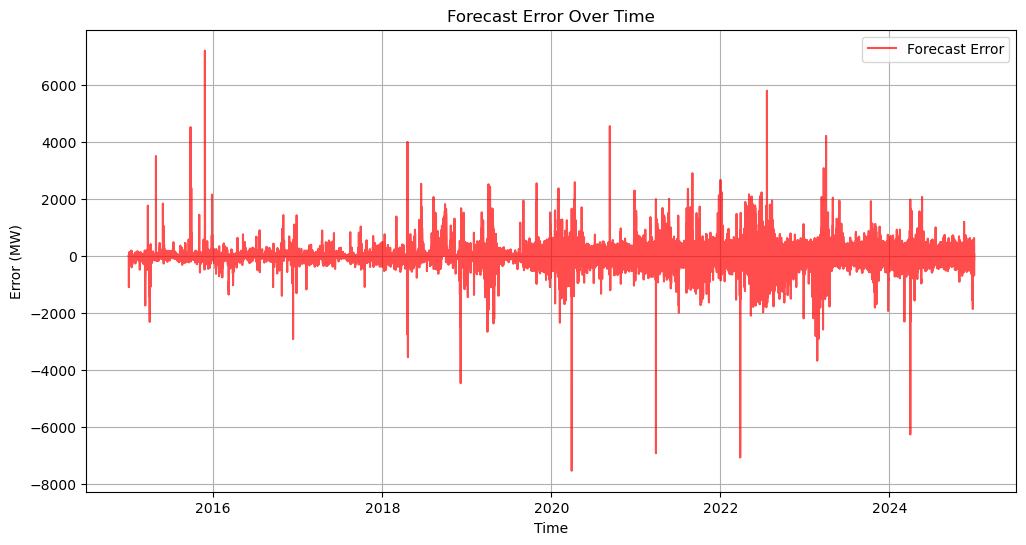

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(all_data['Timestamp'], all_data['Actual Load'] - all_data['Forecast Load'], 
         label='Forecast Error', alpha=0.7, color='red')

plt.xlabel('Time')
plt.ylabel('Error (MW)')
plt.title('Forecast Error Over Time')
plt.legend()
plt.grid()
plt.show()


### Monthly average with group by structure

In [35]:
# Ensure 'Timestamp' is in datetime format (if not already)
all_data['Timestamp'] = pd.to_datetime(all_data['Timestamp'], errors='coerce')

# Extract 'Year' and 'Month' from 'Timestamp'
all_data['Year'] = all_data['Timestamp'].dt.year
all_data['Month'] = all_data['Timestamp'].dt.month

# Group by 'Year' and 'Month' and calculate averages
monthly_avg = all_data.groupby(['Year', 'Month'], as_index=True)[['Forecast Load', 'Actual Load']].mean()

# Display the result
print(monthly_avg)



            Forecast Load   Actual Load
Year Month                             
2015 1       18279.598118  18265.288978
     2       18032.017857  18023.107143
     3       16557.501141  16516.821073
     4       14570.009722  14490.023611
     5       13318.690860  13331.307796
...                   ...           ...
2024 8       12381.735215  12449.002688
     9       13258.136111  13290.179167
     10      15245.664430  15258.950336
     11      17546.643056  17564.827778
     12      18502.290323  18469.852151

[120 rows x 2 columns]


## Next Steps

**Completed:**
 Data Cleaning
 Data Exploration
 Basic Visualization

**To Do Next:**
 Feature Engineering (Rolling Averages, Lag Features)
 Outlier Detection & Handling
 Correlation Analysis
 Seasonality & Trend Analysis
 Data Imbalance Check


## Feature Engineering

### Why is Feature Engineering Important?
To improve forecasting accuracy, we create new time-dependent features such as:
- **Lag Features:** Previous values (e.g., `t-1`, `t-24`) to capture trends.
- **Rolling Averages:** Smooth short-term fluctuations.

### Steps:
1. Compute lag features.
2. Calculate rolling averages.
3. Add day-of-week and month indicators.


               Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8640 2015-12-26 23:00:00        14920.0      17065.0  2015     12   26    23   
8641 2015-12-27 00:00:00        16696.0      16695.0  2015     12   27     0   
8642 2015-12-27 01:00:00        16494.0      16494.0  2015     12   27     1   
8643 2015-12-27 02:00:00        16412.0      16411.0  2015     12   27     2   
8644 2015-12-27 03:00:00        16369.0      16369.0  2015     12   27     3   

      Weekday  Is_Weekend  Lag_1H_Forecast  ...  Rolling_6H_Actual  \
8640        5           1          17328.0  ...       17795.666667   
8641        6           1          14920.0  ...       17522.166667   
8642        6           1          16696.0  ...       17235.500000   
8643        6           1          16494.0  ...       16952.333333   
8644        6           1          16412.0  ...       16726.833333   

      Rolling_24H_Forecast  Rolling_24H_Actual  Rolling_168H_Forecast  \
8640          16621.00000

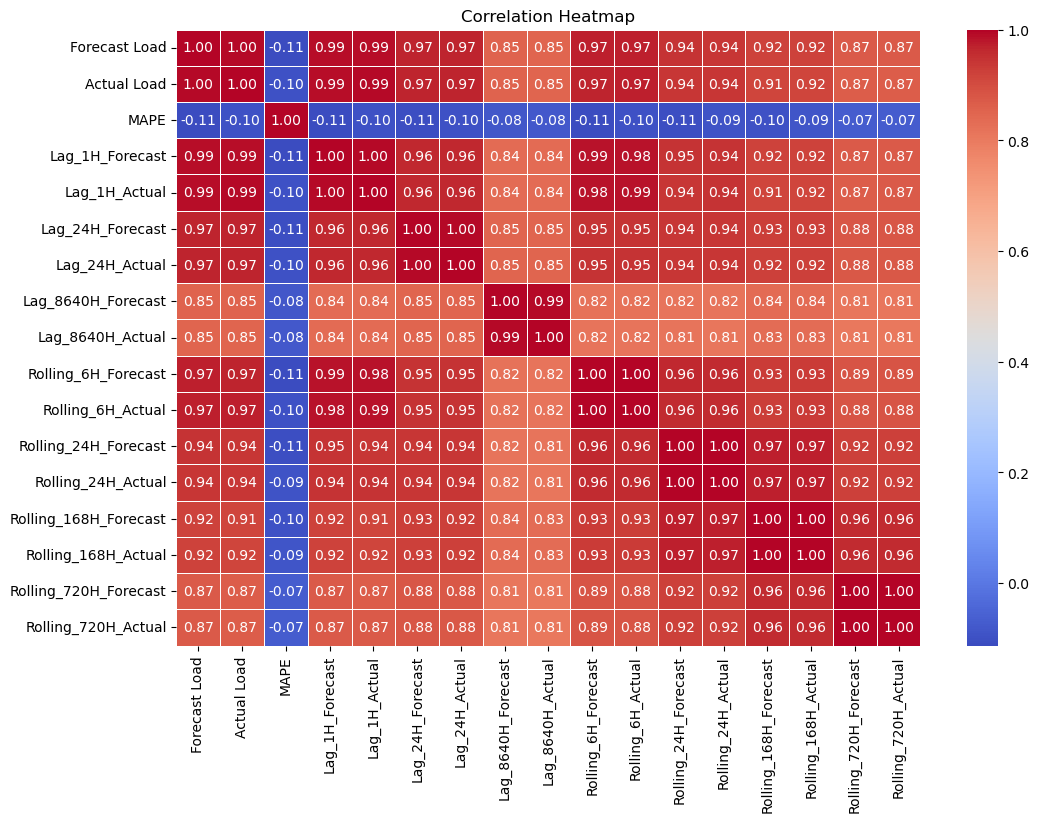

In [36]:
# Convert 'Timestamp' to datetime
all_data['Timestamp'] = pd.to_datetime(all_data['Timestamp'], errors='coerce')

# Extracting additional time-based features
all_data.loc[:, 'Year'] = all_data['Timestamp'].dt.year
all_data.loc[:, 'Month'] = all_data['Timestamp'].dt.month
all_data.loc[:, 'Day'] = all_data['Timestamp'].dt.day
all_data.loc[:, 'Hour'] = all_data['Timestamp'].dt.hour
all_data.loc[:, 'Weekday'] = all_data['Timestamp'].dt.weekday  # Monday=0, Sunday=6
all_data.loc[:, 'Is_Weekend'] = all_data['Weekday'].isin([5, 6]).astype(int)

# Creating lag features
    # One hour lag
all_data.loc[:, 'Lag_1H_Forecast'] = all_data['Forecast Load'].shift(1)
all_data.loc[:, 'Lag_1H_Actual'] = all_data['Actual Load'].shift(1)
    # One Day lag
all_data.loc[:, 'Lag_24H_Forecast'] = all_data['Forecast Load'].shift(24)
all_data.loc[:, 'Lag_24H_Actual'] = all_data['Actual Load'].shift(24)
    # One Year lag
all_data.loc[:, 'Lag_8640H_Forecast'] = all_data['Forecast Load'].shift(8640)
all_data.loc[:, 'Lag_8640H_Actual'] = all_data['Actual Load'].shift(8640)


# Rolling mean features
    # Six hour window
all_data.loc[:, 'Rolling_6H_Forecast'] = all_data['Forecast Load'].rolling(window=6, min_periods=1).mean()
all_data.loc[:, 'Rolling_6H_Actual'] = all_data['Actual Load'].rolling(window=6, min_periods=1).mean()
    # One day window
all_data.loc[:, 'Rolling_24H_Forecast'] = all_data['Forecast Load'].rolling(window=24, min_periods=1).mean()
all_data.loc[:, 'Rolling_24H_Actual'] = all_data['Actual Load'].rolling(window=24, min_periods=1).mean()
    # One week window
all_data.loc[:, 'Rolling_168H_Forecast'] = all_data['Forecast Load'].rolling(window=168, min_periods=1).mean()
all_data.loc[:, 'Rolling_168H_Actual'] = all_data['Actual Load'].rolling(window=168, min_periods=1).mean()
    # One month window
all_data.loc[:, 'Rolling_720H_Forecast'] = all_data['Forecast Load'].rolling(window=720, min_periods=1).mean()
all_data.loc[:, 'Rolling_720H_Actual'] = all_data['Actual Load'].rolling(window=720, min_periods=1).mean()

"""    # One year window
all_data.loc[:, 'Rolling_8640H_Forecast'] = all_data['Forecast Load'].rolling(window=8640, min_periods=1).mean()
all_data.loc[:, 'Rolling_8640H_Actual'] = all_data['Actual Load'].rolling(window=8640, min_periods=1).mean()
"""

# Difference between forecast and actual load
all_data.loc[:, 'Load_Error'] = all_data['Forecast Load'] - all_data['Actual Load']
all_data.loc[:, 'Absolute_Error'] = abs(all_data['Load_Error'])

# Percentage error (MAPE) with a safeguard for division by zero
all_data.loc[:, 'MAPE'] = (all_data['Absolute_Error'] / (all_data['Actual Load'] + 1e-6)) * 100

# Handling missing values that may arise due to lag features
all_data = all_data.dropna()

# Display processed data sample
print(all_data.head())


# Select relevant numerical columns only (excluding non-existent or highly NaN features)
columns_to_include = [
    'Forecast Load', 'Actual Load', 'MAPE', 
    'Lag_1H_Forecast', 'Lag_1H_Actual', 'Lag_24H_Forecast', 'Lag_24H_Actual', 'Lag_8640H_Forecast', 'Lag_8640H_Actual',
    'Rolling_6H_Forecast', 'Rolling_6H_Actual', 'Rolling_24H_Forecast', 'Rolling_24H_Actual', 
    'Rolling_168H_Forecast', 'Rolling_168H_Actual', 'Rolling_720H_Forecast', 'Rolling_720H_Actual'
]

# Ensure only existing columns are selected (avoiding errors)
columns_to_include = [col for col in columns_to_include if col in all_data.columns]

# Compute correlation matrix
corr_matrix = all_data[columns_to_include].corr()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


## Outlier Detection

### Why is it Important?
Outliers can distort predictions and must be identified.

### Steps:
1. **Visualize using Box Plots**
2. **Compute Z-Scores or IQR**
3. **Decide: Remove or Transform?**


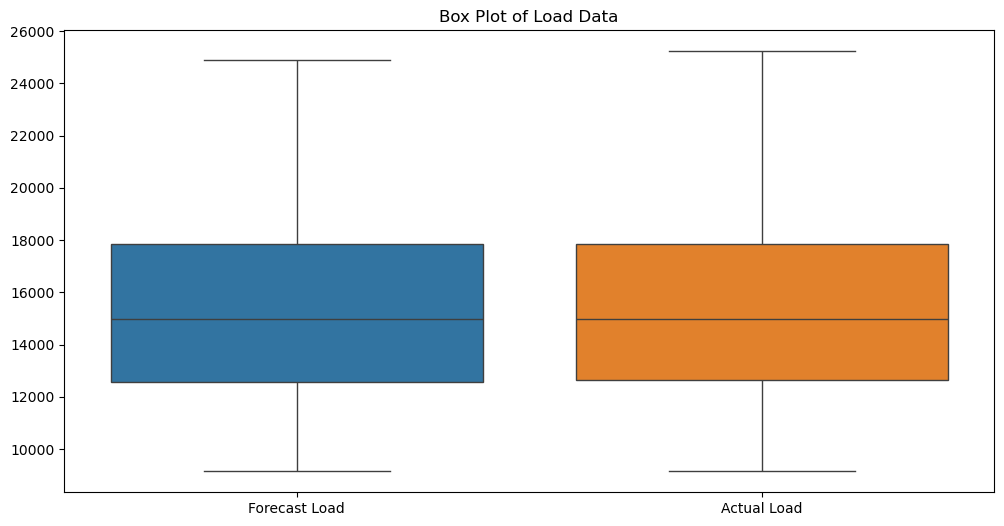

In [37]:
### *Outlier Detection Code Below:*

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=all_data[['Forecast Load', 'Actual Load']])
plt.title('Box Plot of Load Data')
plt.show()


## Correlation Analysis

### Why is it Important?
Identifying relationships between variables helps remove redundancy.

### Steps:
1. Compute correlation matrix.
2. Visualize with a heatmap.
3. Identify highly correlated features.


In [38]:
### *Correlation Analysis Code Below:*

from scipy.stats import zscore

all_data['Forecast_Z'] = zscore(all_data['Forecast Load'])
all_data['Actual_Z'] = zscore(all_data['Actual Load'])

# Show rows where the absolute Z-score is greater than 3 (potential outliers)
outliers = all_data[(all_data['Forecast_Z'].abs() > 3) | (all_data['Actual_Z'].abs() > 3)]
print(outliers)


Q1 = all_data[['Forecast Load', 'Actual Load']].quantile(0.25)
Q3 = all_data[['Forecast Load', 'Actual Load']].quantile(0.75)
IQR = Q3 - Q1

outliers_iqr = all_data[((all_data[['Forecast Load', 'Actual Load']] < (Q1 - 1.5 * IQR)) | 
                         (all_data[['Forecast Load', 'Actual Load']] > (Q3 + 1.5 * IQR))).any(axis=1)]

print(outliers_iqr)


                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
53438 2021-02-04 08:00:00        24901.0      25146.0  2021      2    4     8   
53462 2021-02-05 08:00:00        24766.0      24991.0  2021      2    5     8   
53463 2021-02-05 09:00:00        24706.0      25047.0  2021      2    5     9   
53606 2021-02-11 08:00:00        24825.0      24977.0  2021      2   11     8   
53631 2021-02-12 09:00:00        24816.0      25230.0  2021      2   12     9   

       Weekday  Is_Weekend  Lag_1H_Forecast  ...  Rolling_24H_Actual  \
53438        3           0          24690.0  ...        22931.916667   
53462        4           0          24494.0  ...        23278.333333   
53463        4           0          24766.0  ...        23281.833333   
53606        3           0          24267.0  ...        23050.708333   
53631        4           0          24654.0  ...        23071.791667   

       Rolling_168H_Forecast  Rolling_168H_Actual  Rolling_720H_Forecast  \
5343

## Time-Series Decomposition

### Why?
- Helps visualize long-term trends.
- Identifies seasonal patterns.

### Steps:
1. Use `seasonal_decompose()`.
2. Plot components (Trend, Seasonality, Residuals).
3. Decide if detrending is needed.


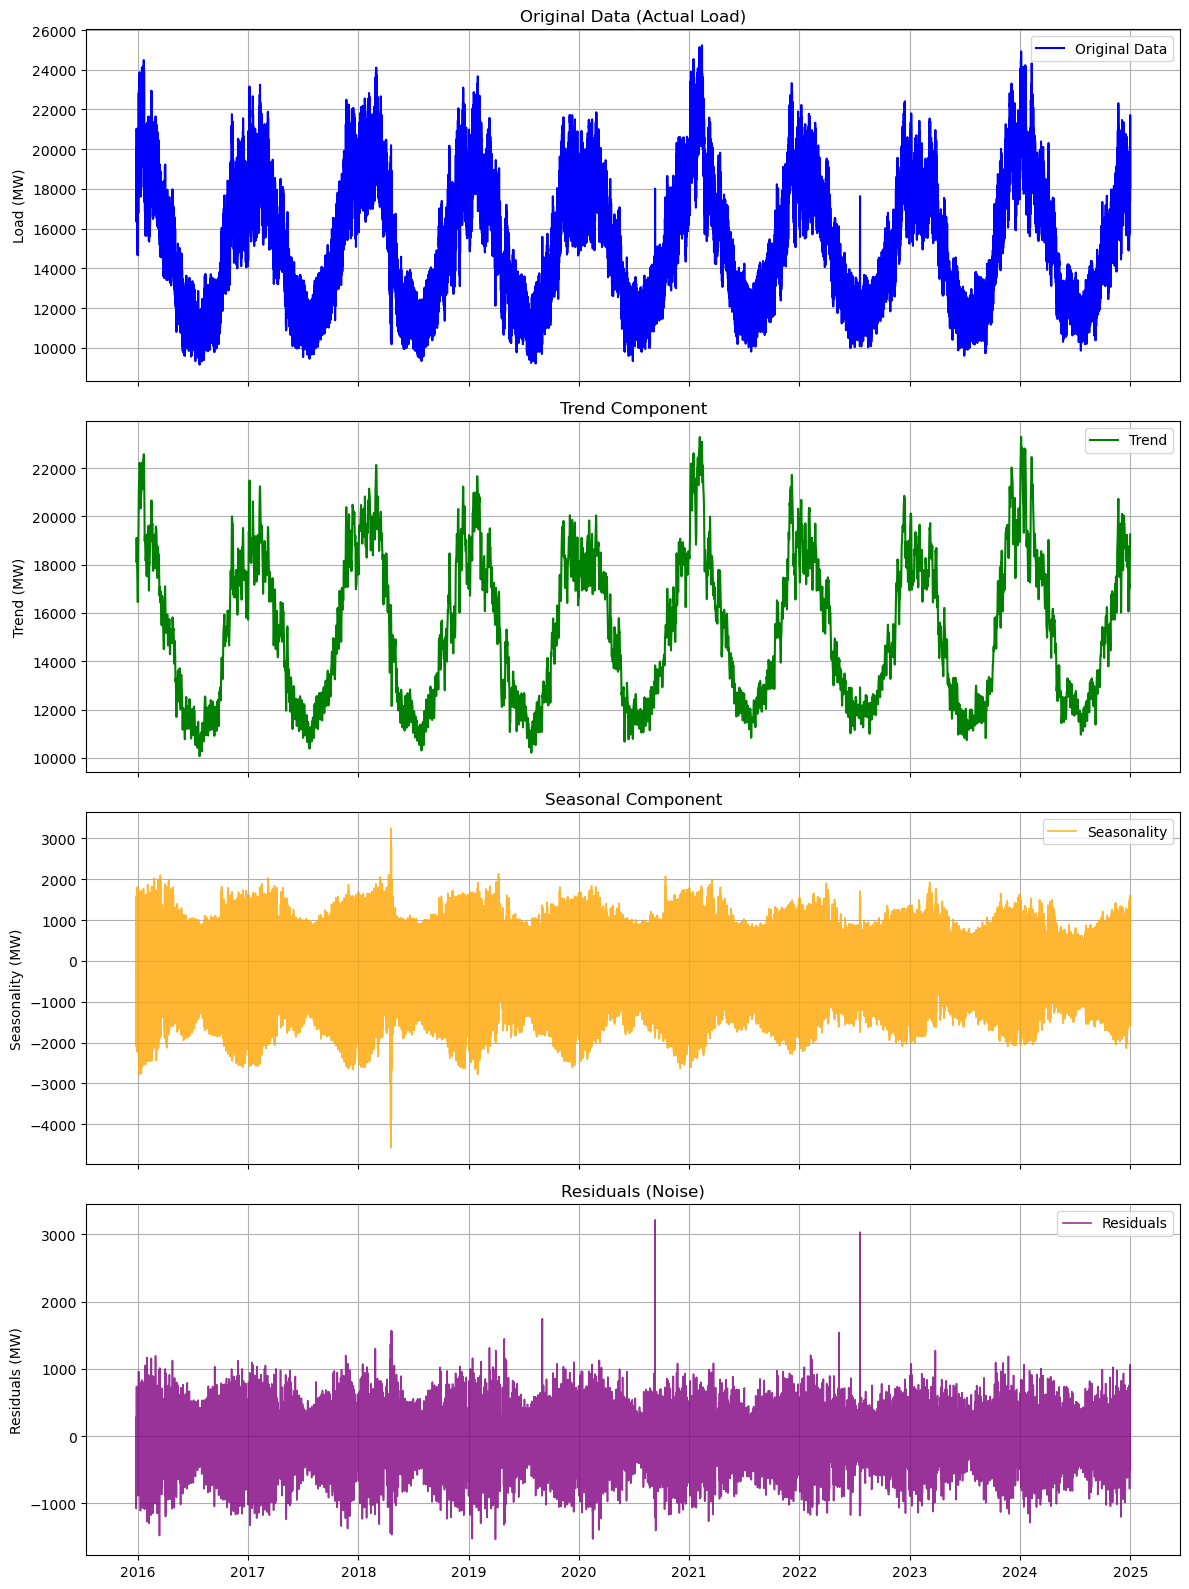

In [39]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Ensure the Timestamp is set as the index and sorted
ts = all_data.set_index('Timestamp').sort_index()

# Choose the time series to decompose (drop missing values if necessary)
series = ts['Actual Load'].dropna()

# Specify the period for the seasonal component.
# For hourly data with daily seasonality, period=24; adjust as needed.
stl = STL(series, period=24)
result = stl.fit()

# Plot each component separately for better clarity
fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

# Original Data
axes[0].plot(series, label='Original Data', color='blue', linewidth=1.5)
axes[0].set_title('Original Data (Actual Load)')
axes[0].set_ylabel('Load (MW)')
axes[0].legend()
axes[0].grid(True)

# Trend Component
axes[1].plot(result.trend, label='Trend', color='green', linewidth=1.5)
axes[1].set_title('Trend Component')
axes[1].set_ylabel('Trend (MW)')
axes[1].legend()
axes[1].grid(True)

# Seasonal Component
axes[2].plot(result.seasonal, label='Seasonality', color='orange', linewidth=1.2, alpha=0.8)
axes[2].set_title('Seasonal Component')
axes[2].set_ylabel('Seasonality (MW)')
axes[2].legend()
axes[2].grid(True)

# Residuals (Noise)
axes[3].plot(result.resid, label='Residuals', color='purple', linewidth=1.2, alpha=0.8)
axes[3].set_title('Residuals (Noise)')
axes[3].set_ylabel('Residuals (MW)')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()
